In [1]:
# Import GBApy
import gba

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1. Create a non full column rank model

To create a non full-column-rank toy model, use the script `./scripts/generate_toy_model.py`. Command line parameters are `-path` (the path where to save the CSV model) and `-efms` (the number of EFMs). E.g.:

```bash
python ./scripts/generate_toy_model.py -path ./toy_models -efms 2
```

The name of the model is always "EFMx" with "x" the number of EFMs (here, EFM2).

<div align="center" style="max-width:500px;display:block;margin:auto;">

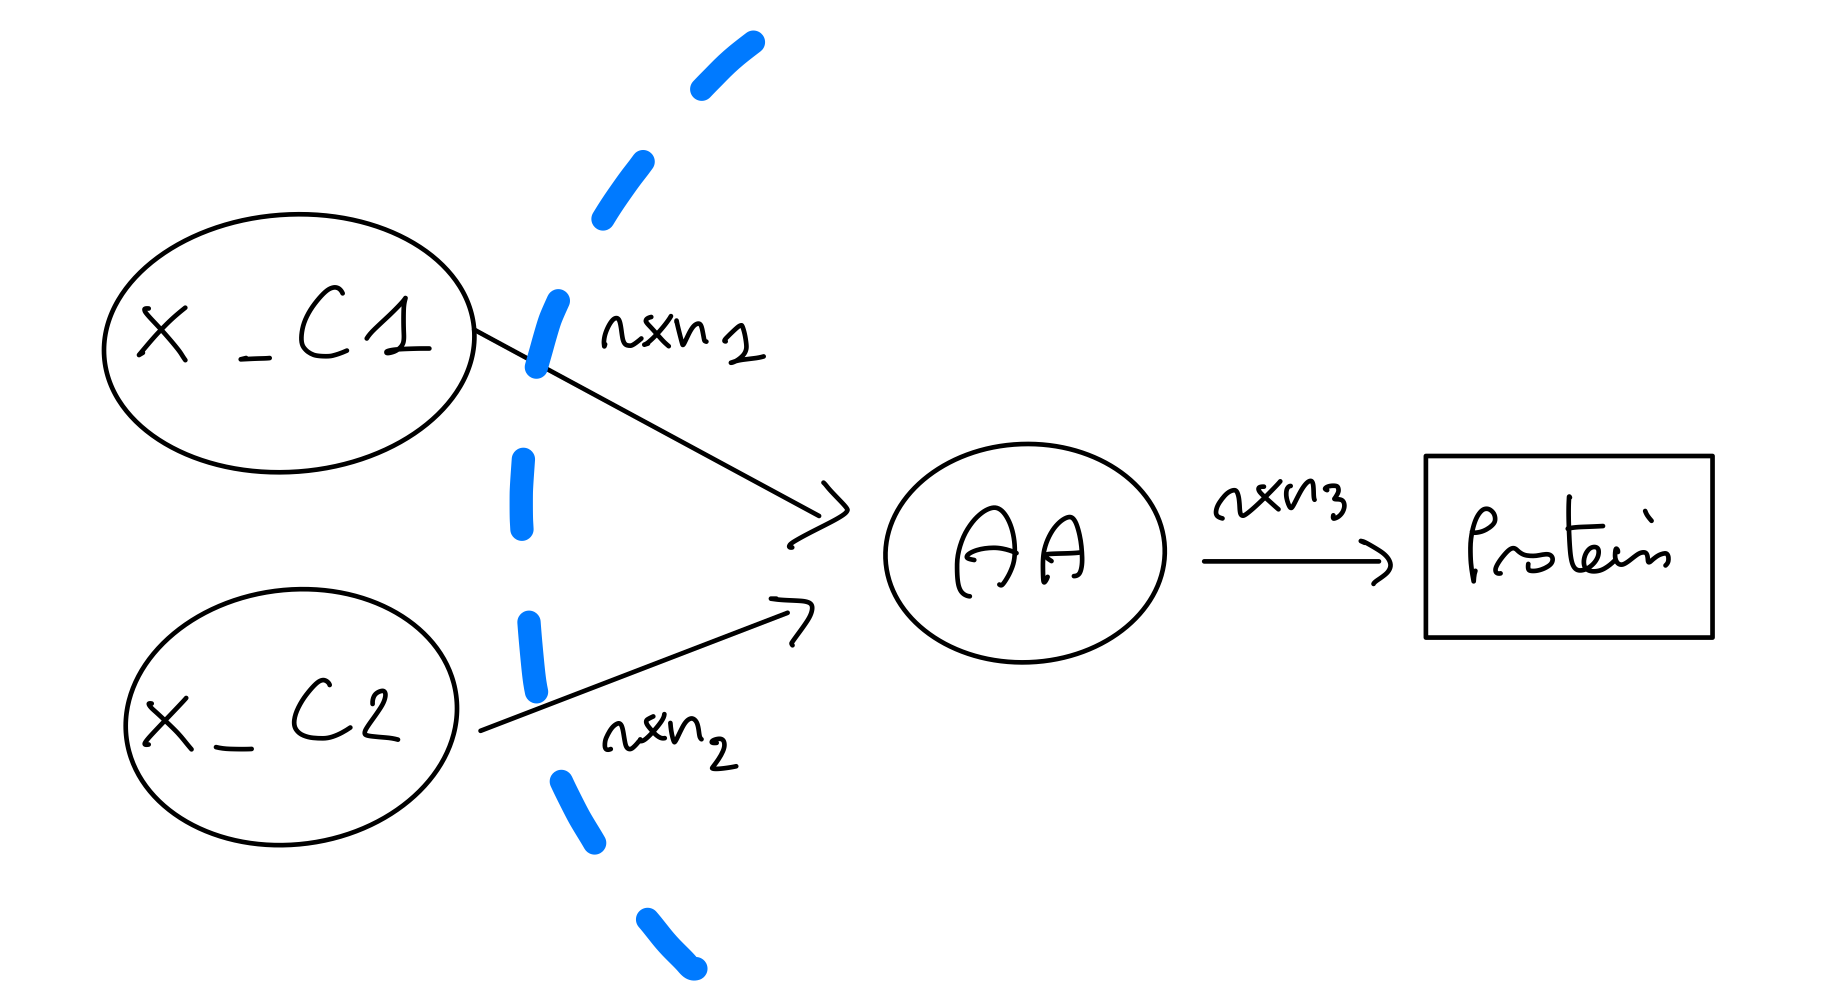

</div>

# 2. Load the model + basic manipulations

## 2.1. Load the model

In [2]:
model = gba.read_csv_model("EFM2", "../toy_models")
model.summary()

Category,Count
Nb metabolites,4
Nb external metabolites,2
Nb internal metabolites,2
Category,Count
Nb reactions,3
Nb exchange reactions,2
Nb internal reactions,0
Category,Count
Column rank,2
Is full column rank?,False


Note that the model is not full column rank (table "Matrix rank").

In [3]:
model.kcat_f[1] = 10

For this model, the $k_\text{cat}$ value of the reaction `rxn1` (10 h<sup>-1</sup>) is slightly higher than for `rxn2` (9.99 h<sup>-1</sup>). We can expect both EFMs to have very close optimal growth rates.

## 2.2. Calculate an initial solution and optimize the model

In [4]:
model.solve_local_linear_problem()
model.compute_optima()

0.1989281177520752

In [5]:
model.optima_data

,condition,mu,density,converged,run_time,f_rxn1,f_rxn2,f_Ribosome
0,1,0.676228,1.0,1,0.197235,1.0,0.0,0.93472


The optimum is found to be $\mu \approx 0.677$. But we don't know if this is the global optimum, as the model is not full column rank.

## 2.3. Run a gradient ascent from the initial LP solution

The trajectory indeed converges toward the local optimum we found above ($\mu \approx 0.677$).

In [6]:
model.set_f0(model.LP_solution)
model.gradient_ascent(condition_id="1", track=True, variables=["f", "v", "p", "b", "c"])

(True, 0.9192070960998535)

In [7]:
model.GA_tracker

,label,condition,dt,t,mu,fixed,f_rxn1,f_rxn2,f_Ribosome,v_rxn1,v_rxn2,v_Ribosome,p_rxn1,p_rxn2,p_Ribosome,b_AA,b_Protein,c_AA,c_Protein
0,1,1,0.01,0.0,0.67341,0,1.0,0.0,0.95,228.959402,0.0,217.511432,251.855343,0.0,71.144657,0.05,0.95,17.0,323.0
1,1,1,0.01,0.01,0.674853,1,1.0,0.0,0.945795,229.450169,0.0,217.012842,252.395186,0.0,69.175143,0.054205,0.945795,18.429671,321.570329
2,1,1,0.01,0.02,0.675479,2,1.0,0.0,0.943079,229.663025,0.0,216.590417,252.629327,0.0,68.017594,0.056921,0.943079,19.353079,320.646921
3,1,1,0.01,0.03,0.675796,3,1.0,0.0,0.941167,229.770716,0.0,216.252548,252.747788,0.0,67.248891,0.058833,0.941167,20.003321,319.996679
4,1,1,0.01,0.04,0.67597,4,1.0,0.0,0.939759,229.829775,0.0,215.984622,252.812752,0.0,66.705341,0.060241,0.939759,20.481907,319.518093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,1,1,0.0,0.718344,0.676228,1032,1.0,0.0,0.93472,229.917535,0.0,214.908554,252.909289,0.0,64.895563,0.06528,0.93472,22.195148,317.804852
1033,1,1,0.0,0.718344,0.676228,1033,1.0,0.0,0.93472,229.917535,0.0,214.908554,252.909289,0.0,64.895563,0.06528,0.93472,22.195148,317.804852
1034,1,1,0.0,0.718344,0.676228,1034,1.0,0.0,0.93472,229.917535,0.0,214.908554,252.909289,0.0,64.895563,0.06528,0.93472,22.195148,317.804852
1035,1,1,0.0,0.718344,0.676228,1035,1.0,0.0,0.93472,229.917535,0.0,214.908554,252.909289,0.0,64.895563,0.06528,0.93472,22.195148,317.804852


In [8]:
fig = model.create_figure("Growth rate vs time")
model.add_trajectory(fig, source="GA", x_var="t", y_var="mu", name="Growth rate")
fig.show()

In [9]:
fig = model.create_figure("Ribosomal fraction")
model.add_trajectory(fig, source="GA", x_var="t", y_var="b_Protein", name="Ribosomal fraction")
fig.show()

## 2.4. Explore the fitness landscape of the EFM2 model

We will now vary the flux of the reaction `rxn1` between 0.0 and its maximum (i.e. when the solution is on the EFM including `rxn1`) and draw the fitness landscape of the model EFM2 when the growth rate is maximal.
Therefore, we will not visualise the whole solution space, but just the line of maximal growth rate. It will allow us to visualize the two local optima.

In the specific case of this toy model, as all the reactions of interest (`rxn1`, `rxn2`, etc) are transporters, the maximal value will always be 1, because the quantity of matter entering the cell must sum up to 1 (when normalized).

In [10]:
res = pd.DataFrame()
for rxn1 in np.arange(0, 1.1, 0.1):
    model.clear_constant_reactions()
    model.add_constant_reaction("rxn1", rxn1)
    model.solve_local_linear_problem()
    model.compute_optima()
    res = pd.concat([res, model.optima_data])
res

,condition,mu,density,converged,run_time,f_rxn1,f_rxn2,f_Ribosome
0,1,0.676228,1.0,1,0.185795,0.0,1.0,0.93472
0,1,0.676228,1.0,1,0.174521,0.1,0.9,0.93472
0,1,0.676228,1.0,1,0.207779,0.2,0.8,0.93472
0,1,0.676228,1.0,1,0.312356,0.3,0.7,0.93472
0,1,0.676228,1.0,1,0.218236,0.4,0.6,0.93472
0,1,0.676228,1.0,1,0.176893,0.5,0.5,0.93472
0,1,0.676228,1.0,1,0.173246,0.6,0.4,0.93472
0,1,0.676228,1.0,1,0.212491,0.7,0.3,0.93472
0,1,0.676228,1.0,1,0.223776,0.8,0.2,0.93472
0,1,0.676228,1.0,1,0.206096,0.9,0.1,0.93472


In [11]:
fig = model.create_figure("Fitness landscape")
model.add_trajectory(fig, source="data", x_var="f_rxn1", y_var="mu", name="Fitness landscape", data=res)
model.add_trajectory(fig, source="data", x_var="f_rxn2", y_var="mu", name="Fitness landscape", data=res)
fig.show()